## Functions

In [2]:
from helpers import write_result, load_malawi_data, split_data, SAVE_PATH

from pathlib import Path

import pandas as pd
import numpy as np


import seaborn as sns
sns.set_theme()

from multiprocessing import Pool

path_to_feature_sets = Path('/home/selker/eop/eop/select_predictors/2019')

from pathlib import Path
from multiprocessing import Pool

import numpy as np
import pandas as pd
from opt_targeted_transfers import (
    ConditionalTargetedTransfers,
    HybridTargetedTransfers,
    UnconditionalTargetedTransfers,
    GapTargetedTransfers,
    OracleGapTargetedTransfers,
    OraclePovertyRateTargetedTransfers,
    BinaryTargetedTransfers,
    BinaryGapTargetedTransfers
)

from helpers import write_result, load_malawi_data, split_data, SAVE_PATH

def run_gap_targeting_grid(
    country="malawi",
    save="malawi_results.csv",
    features=None,
    extra_run_labels=None,
    district=None,
    ns_quantiles=[20],
    hidden_layer_sizes=[64],
    lambdas=None  # iterable
):

    save.mkdir(exist_ok=True, parents=True)

    d = len(features)
    
    if extra_run_labels is None:
        extra_run_labels = dict()

    if features is None:
        # TODO: Redo this signature
        raise ValueError('Specify some features!')

    # A semi-hack to replace the incorrect d that was populated before.
    extra_run_labels.update({'d': d})
    
    X, y, r, _ = load_malawi_data(features, district)

    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    base_name = f'{country}_d={d}_gap'

    if lambdas is None:
        raise ValueError('need lambdas')

    tt = GapTargetedTransfers(c_bar=2.15)

    for n_quantiles in ns_quantiles:
        
        for hidden_layer_size in hidden_layer_sizes:

            tt.fit(X_train, y_train, r_train, n_quantiles=n_quantiles, hidden_layer_size=hidden_layer_size)
        
            for lambda_ in lambdas:
            
                tt.run_opt(
                    X_test,
                    lambda_
                )
                assignments = tt.opt_policy(X_test)

                res = tt.evaluate(X_test, y_test, r_test)
                write_result(
                    save / "{}.csv".format(country), 
                    res,
                    {
                        **extra_run_labels, 
                        'policy_type': 'gap',
                        'lambda': lambda_,
                        'n_quantiles': n_quantiles,
                        'hidden_layer_size': hidden_layer_size
                    }
                )
                tt.evaluate_equity(X_test, y_test, r_test, path=save / f'equity_continuous_gap_lambda_{lambda_}.csv')


    return assignments


def run_oracle_gap_targeting(
    country="malawi",
    save=None,
    uncondtols=None,
    extra_run_labels=None,
    district=None,
    schemes=None,
):
    
    if uncondtols is None:
        raise ValueError('specify tolerances')

    if schemes is None:
        raise ValueError('specify schemes')
        
    assert save is not None

    save.mkdir(exist_ok=True, parents=True)
    
    if extra_run_labels is None:
        extra_run_labels = dict()
    
    X, y, r, _ = load_malawi_data([], district)

    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    for unconditional_tolerance in uncondtols:
        for scheme in schemes:
    
            tt = OracleGapTargetedTransfers(
                c_bar=2.15, scheme=scheme, unconditional_tolerance=unconditional_tolerance
            )
        
            tt.run_opt(
                y_test, r_test
            )
            res = tt.evaluate(X_test, y_test, r_test)

            write_result(
                save / "{}.csv".format(country), 
                res,
                {
                    **extra_run_labels, 
                    'policy_type': 'oracle_gap',
                    'oracle_gap_scheme': scheme
                }
            )
            tt.evaluate_equity(X_test, y_test, r_test, path=save / f'equity_oracle_gap_uncondtol_{unconditional_tolerance}_scheme_{scheme}.csv')


def run_binary_gap_targeting_grid(
    country="malawi",
    save="malawi_results.csv",
    features=None,
    extra_run_labels=None,
    district=None,
    budgets=None,
    hidden_layer_sizes=[64],
    num_t_values=20
):
    if budgets is None:
        raise ValueError('specify budgets')
    assert save is not None
    save.mkdir(exist_ok=True, parents=True)
    
    if extra_run_labels is None:
        extra_run_labels = dict()
    
    X, y, r, _ = load_malawi_data(features, district)

    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    for budget in budgets:

        for hidden_layer_size in hidden_layer_sizes:

            tt = BinaryGapTargetedTransfers(c_bar=2.15, budget=budget)
            tt.fit(X_train, y_train, r_train, hidden_layer_size=hidden_layer_size, num_t_values=num_t_values)
            tt.run_opt(X_test, r_test)

            res = tt.evaluate(X_test, y_test, r_test)
            write_result(
                save / "{}.csv".format(country), 
                res,
                {
                    **extra_run_labels, 
                    'policy_type': 'binary_gap',
                    'budget': budget,
                    'hidden_layer_size': hidden_layer_size,
                    't': tt.t
                }
            )

            tt.evaluate_equity(X_test, y_test, r_test, path=save / f'equity_binary_gap_budget_{budget}.csv')
    

def run_oracle_rate_targeting(
    country='malawi',
    uncondtols=None,  # iterable
    save=None,
    district=None,
    extra_run_labels=None
):
    if uncondtols is None:
        raise ValueError('specify tolerances')
        
    assert save is not None

    save.mkdir(exist_ok=True, parents=True)
    
    if extra_run_labels is None:
        extra_run_labels = dict()
    
    X, y, r, _ = load_malawi_data([], district)

    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    for unconditional_tolerance in uncondtols:    
        tt = OraclePovertyRateTargetedTransfers(
            c_bar=2.15, unconditional_tolerance=unconditional_tolerance
        )
    
        tt.run_opt(
            y_test, r_test
        )
        res = tt.evaluate(X_test, y_test, r_test)

        write_result(
            save / "{}.csv".format(country), 
            res,
            {
                **extra_run_labels, 
                'policy_type': 'oracle_rate',
            }
        )   
        tt.evaluate_equity(X_test, y_test, r_test, path=save / f'equity_oracle_rate_uncondtol_{unconditional_tolerance}.csv')


def run_rate_targeting(
    country="malawi",
    policy_type="unconditional",
    method="qr",
    condtols=None,  # iterable
    uncondtols=None,  # iterable
    save=None,
    features=None,
    extra_run_labels=None,
    district=None
):

    assert save is not None
    save.mkdir(exist_ok=True, parents=True)

    d = len(features)
    
    if extra_run_labels is None:
        extra_run_labels = dict()

    if features is None:
        raise ValueError('Specify some features!')

    # A semi-hack to replace the incorrect d that was populated before.
    extra_run_labels.update({'d': d})
    
    X, y, r, _ = load_malawi_data(features, district)

    
    (X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
        X=X, y=y, r=r, p=0.6
    )

    base_name = f'{country}_d={d}_{policy_type}'

    if policy_type == "unconditional":

        tt = UnconditionalTargetedTransfers(c_bar=2.15)
        
        tt.fit(X_train, y_train, r_train)
        for tol in uncondtols:
            tt.set_unconditional_tolerance(tol)
            tt.run_opt(
                    X_test,
                    r_test,
                    path=save / f'{base_name}_uncondtol={tol}_opt.csv'
                )
            res = tt.evaluate(X_test, y_test, r_test)
            write_result(save / "{}.csv".format(country), res, extra_run_labels)
            tt.evaluate_equity(
                X_test,
                y_test,
                path=save / f'equity_{base_name}_uncondtol={tol}_opt.csv'
            )

    elif policy_type == "conditional":
        tt = ConditionalTargetedTransfers(method=method, c_bar=2.15)

        if method == "density":
            tt.fit(X_train, y_train, r_train)
            for tol in condtols:
                tt.set_conditional_tolerance(tol)
                tt.run_opt(
                        X_test,
                        r_test,
                    )
                res = tt.evaluate(X_test, y_test, r_test)
                print('saving')
                write_result(save / f'{country}.csv', res, extra_run_labels)
                tt.evaluate_equity(
                    X_test,
                    y_test,
                    path=save / f'equity_{base_name}_undcondtol={tol}_condtol={tol}'
                )
        elif method == "qr":
            for tol in condtols:
                tt.set_conditional_tolerance(tol)
                tt.fit(X_train, y_train, r_train)
                tt.run_opt(
                        X_test,
                        r_test,
                    )
                res = tt.evaluate(X_test, y_test, r_test)
                write_result(save / f'{country}.csv', res, extra_run_labels)
                tt.evaluate_equity(
                    X_test,
                    y_test,
                    path=save / f'equity_{base_name}_uncondtol={tol}_condtol={tol}.csv'
                )

    elif policy_type == "hybrid":

        tt = HybridTargetedTransfers(c_bar=2.15)
        tt.fit(X_train, y_train, r_train)
        
        for tol1 in uncondtols:
            for tol2 in condtols:
                tt.set_conditional_tolerance(tol2)
                tt.set_unconditional_tolerance(tol1)
                tt.run_opt(
                    X_test,
                    r_test,
                    path=save / f'{base_name}_uncondtol={tol1}_condtol={tol2}_opt.csv'
                )
                res = tt.evaluate(X_test, y_test, r_test)
                write_result(save / "{}.csv".format(country), res, extra_run_labels)
                tt.evaluate_equity(
                    X_test,
                    y_test,
                    path=save / f'equity_{base_name}_uncondtol={tol1}_condtol={tol2}.csv'
                )
    elif policy_type == "binary":
        tt = BinaryTargetedTransfers(c_bar=2.15)
        tt.fit(X_train, y_train, r_train)

        for tol1 in uncondtols:
            if condtols is None:
                condtols = [1.0]
            for tol2 in condtols:
                tt.set_conditional_tolerance(tol2)
                tt.set_unconditional_tolerance(tol1)
                tt.run_opt(X_test=X_test, r_test=r_test)
                res = tt.evaluate(X_test, y_test, r_test)
                write_result(save / "{}.csv".format(country), res, extra_run_labels)
                tt.evaluate_equity(
                    X_test,
                    y_test,
                    path=save / f'equity_{base_name}_uncondtol={tol1}_condtol={tol2}_opt.csv'
                )

def run_rate_targeting_grid(
    features, 
    district=None, 
    extra_run_labels=None,  # dictionary
    ds=None,  # number(s) of features to keep
    policy_types=None,  # iterable: kinds of policy
    quantile_methods=None,  # iterable
    condtols=None,  # iterable
    uncondtols=None,  # iterable
    n_cores=24,  # int: number of cores
    save=None
):
    
    assert save is not None
    args = []

    if ds is None:
        ds=[len(features)]

    for d in ds:
        features_d = features[:d]
        for policy_type in policy_types:
            if policy_type == "conditional":
                for quantile_method in quantile_methods:

                    args.append(
                        {
                            'policy_type': policy_type, 
                            'features': features_d,
                            'method': quantile_method, 
                            'condtols': condtols,
                        }
                    )

            elif policy_type == "unconditional":

                args.append(
                        {
                            'policy_type': policy_type,  
                            'features': features_d,
                            'uncondtols': uncondtols,
                        }
                )

            elif policy_type == "hybrid":
                args.append(
                        {
                            
                            'policy_type': policy_type,  
                            'features': features_d,
                            'uncondtols': uncondtols,
                            'condtols': condtols
                        }
                )
            elif policy_type == "binary":
                args.append(
                        {
                            'policy_type': policy_type,  
                            'features': features_d,
                            'uncondtols': uncondtols,
                            'condtols': condtols
                        }
                )
    for arg in args:
        arg.update(
            {
                'country': 'malawi', 
                'extra_run_labels': extra_run_labels,
                'district': district,
                'save': save
            }
        )

    if n_cores:

        pool = Pool(n_cores)
    
        pool.map_async(
            _unpack_and_run,
            args,
            error_callback=error_callback
        )
    
        pool.close()
        pool.join()

    else:

        for args_dictionary in args:
            _unpack_and_run(args_dictionary)


# wrap in a local method just in case the main functions get refactored to other files-
# they need to be serializable.
def _unpack_and_run(args_dictionary):
    return run_rate_targeting(
        **args_dictionary
    )

def error_callback(error):
    print(f"Process failed: {str(error)}")

## Rate targeting

### Subnational analysis

In [13]:
%%time

for covariates_file in list((path_to_feature_sets / 'district_level_covariates').iterdir()):
    covariates = pd.read_csv(covariates_file)
    district = covariates_file.stem
    malawi_runs(
        covariates.covariate.values,
        district,
        extra_run_labels={
            'features': f'{district}',
            'with_weights': True
        }
    )

NameError: name 'malawi_runs' is not defined

In [14]:
full_country_covariates = pd.read_csv(path_to_feature_sets / 'covariates_below_5_durable.csv').covariate.values
# full_country_covariates = pd.read_csv(path_to_feature_sets / 'covariates_country_all.csv').covariate.values

run_rate_targeting_grid(
    full_country_covariates,
    n_cores=False,
    extra_run_labels = {
        'features': 'full_country',
        'with_weights': True
    }
)

AssertionError: 

## Gap targeting

In [15]:
selected_durable_verifiable_covariates = pd.read_csv(path_to_feature_sets / 'covariates_below_5_durable.csv').covariate.values
full_set_durable_verifiable_covariates = pd.read_csv(
    path_to_feature_sets / 'full_set_durable_verifiable_covariates.csv'
).covariate.values
mosaiks_nearest_features = pd.read_csv(
    path_to_feature_sets / 'mosaiks_nearest_features.csv'
).covariate.values

non_linear_lambdas = np.concatenate((np.linspace(0, .15, 20, endpoint=False) ,np.linspace(.15, 1, 20)))
non_linear_lambdas.sort()

### Gap targeting

In [ ]:
run_oracle_gap_targeting(
    country="malawi",
    save=SAVE_PATH / 'oracle_gap',
    extra_run_labels=None,
    schemes=['lift_to_line'],
    uncondtols=np.linspace(0, .5, 20)
)

In [16]:
run_gap_targeting_grid(
    features=selected_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'selected_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 220.69it/s, val loss=1.57e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 280.59it/s, val loss=0.0378]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 278.20it/s, val loss=0.0556]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 270.27it/s, val loss=0.0649]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 269.70it/s, val loss=0.0713]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 213.29it/s, val loss=0.0721]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 240.27it/s, val loss=0.066] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 268.68it/s, val loss=0.0554]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 242.38it/s, val loss=0.0361]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 239.74it/s, val loss=7.7e-6] 


{0: [(0.0, 1.0)],
 1: [(0.0, 1.0)],
 2: [(0.0, 1.0)],
 3: [(0.0, 1.0)],
 4: [(0.0, 1.0)],
 5: [(0.0, 1.0)],
 6: [(0.0, 1.0)],
 7: [(0.0, 1.0)],
 8: [(0.0, 1.0)],
 9: [(0.0, 1.0)],
 10: [(0.0, 1.0)],
 11: [(0.0, 1.0)],
 12: [(0.0, 1.0)],
 13: [(0.0, 1.0)],
 14: [(0.0, 1.0)],
 15: [(0.0, 1.0)],
 16: [(0.0, 1.0)],
 17: [(0.0, 1.0)],
 18: [(0.0, 1.0)],
 19: [(0.0, 1.0)],
 20: [(0.0, 1.0)],
 21: [(0.0, 1.0)],
 22: [(0.0, 1.0)],
 23: [(0.0, 1.0)],
 24: [(0.0, 1.0)],
 25: [(0.0, 1.0)],
 26: [(0.0, 1.0)],
 27: [(0.0, 1.0)],
 28: [(0.0, 1.0)],
 29: [(0.0, 1.0)],
 30: [(0.0, 1.0)],
 31: [(0.0, 1.0)],
 32: [(0.0, 1.0)],
 33: [(0.0, 1.0)],
 34: [(0.0, 1.0)],
 35: [(0.0, 1.0)],
 36: [(0.0, 1.0)],
 37: [(0.0, 1.0)],
 38: [(0.0, 1.0)],
 39: [(0.0, 1.0)],
 40: [(0.0, 1.0)],
 41: [(0.0, 1.0)],
 42: [(0.0, 1.0)],
 43: [(0.0, 1.0)],
 44: [(0.0, 1.0)],
 45: [(0.0, 1.0)],
 46: [(0.0, 1.0)],
 47: [(0.0, 1.0)],
 48: [(0.0, 1.0)],
 49: [(0.0, 1.0)],
 50: [(0.0, 1.0)],
 51: [(0.0, 1.0)],
 52: [(0.0, 1.0)],
 53

In [19]:
run_gap_targeting_grid(
    features=selected_durable_verifiable_covariates[:4],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': '4_selected_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 221.71it/s, val loss=0]      


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 277.68it/s, val loss=0.0356]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 292.75it/s, val loss=0.0567]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 289.19it/s, val loss=0.0694]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:00<00:00, 309.31it/s, val loss=0.0748]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 274.29it/s, val loss=0.0749]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 269.29it/s, val loss=0.0699]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 276.59it/s, val loss=0.0568]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 269.72it/s, val loss=0.0365]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 270.55it/s, val loss=0]      


{0: [(0.0, 1.0)],
 1: [(0.0, 1.0)],
 2: [(0.0, 1.0)],
 3: [(0.0, 1.0)],
 4: [(0.0, 1.0)],
 5: [(0.0, 1.0)],
 6: [(0.0, 1.0)],
 7: [(0.0, 1.0)],
 8: [(0.0, 1.0)],
 9: [(0.0, 1.0)],
 10: [(0.0, 1.0)],
 11: [(0.0, 1.0)],
 12: [(0.0, 1.0)],
 13: [(0.0, 1.0)],
 14: [(0.0, 1.0)],
 15: [(0.0, 1.0)],
 16: [(0.0, 1.0)],
 17: [(0.0, 1.0)],
 18: [(0.0, 1.0)],
 19: [(0.0, 1.0)],
 20: [(0.0, 1.0)],
 21: [(0.0, 1.0)],
 22: [(0.0, 1.0)],
 23: [(0.0, 1.0)],
 24: [(0.0, 1.0)],
 25: [(0.0, 1.0)],
 26: [(0.0, 1.0)],
 27: [(0.0, 1.0)],
 28: [(0.0, 1.0)],
 29: [(0.0, 1.0)],
 30: [(0.0, 1.0)],
 31: [(0.0, 1.0)],
 32: [(0.0, 1.0)],
 33: [(0.0, 1.0)],
 34: [(0.0, 1.0)],
 35: [(0.0, 1.0)],
 36: [(0.0, 1.0)],
 37: [(0.0, 1.0)],
 38: [(0.0, 1.0)],
 39: [(0.0, 1.0)],
 40: [(0.0, 1.0)],
 41: [(0.0, 1.0)],
 42: [(0.0, 1.0)],
 43: [(0.0, 1.0)],
 44: [(0.0, 1.0)],
 45: [(0.0, 1.0)],
 46: [(0.0, 1.0)],
 47: [(0.0, 1.0)],
 48: [(0.0, 1.0)],
 49: [(0.0, 1.0)],
 50: [(0.0, 1.0)],
 51: [(0.0, 1.0)],
 52: [(0.0, 1.0)],
 53

In [21]:
run_gap_targeting_grid(
    features=[],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'None'}
)

/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f7ef40461f0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f7ef40461f0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f7ef40461f0> is currently using DataFrameGroupBy.sum. In a future version of pand

{0: [(0.0, 1.0)],
 1: [(0.0, 1.0)],
 2: [(0.0, 1.0)],
 3: [(0.0, 1.0)],
 4: [(0.0, 1.0)],
 5: [(0.0, 1.0)],
 6: [(0.0, 1.0)],
 7: [(0.0, 1.0)],
 8: [(0.0, 1.0)],
 9: [(0.0, 1.0)],
 10: [(0.0, 1.0)],
 11: [(0.0, 1.0)],
 12: [(0.0, 1.0)],
 13: [(0.0, 1.0)],
 14: [(0.0, 1.0)],
 15: [(0.0, 1.0)],
 16: [(0.0, 1.0)],
 17: [(0.0, 1.0)],
 18: [(0.0, 1.0)],
 19: [(0.0, 1.0)],
 20: [(0.0, 1.0)],
 21: [(0.0, 1.0)],
 22: [(0.0, 1.0)],
 23: [(0.0, 1.0)],
 24: [(0.0, 1.0)],
 25: [(0.0, 1.0)],
 26: [(0.0, 1.0)],
 27: [(0.0, 1.0)],
 28: [(0.0, 1.0)],
 29: [(0.0, 1.0)],
 30: [(0.0, 1.0)],
 31: [(0.0, 1.0)],
 32: [(0.0, 1.0)],
 33: [(0.0, 1.0)],
 34: [(0.0, 1.0)],
 35: [(0.0, 1.0)],
 36: [(0.0, 1.0)],
 37: [(0.0, 1.0)],
 38: [(0.0, 1.0)],
 39: [(0.0, 1.0)],
 40: [(0.0, 1.0)],
 41: [(0.0, 1.0)],
 42: [(0.0, 1.0)],
 43: [(0.0, 1.0)],
 44: [(0.0, 1.0)],
 45: [(0.0, 1.0)],
 46: [(0.0, 1.0)],
 47: [(0.0, 1.0)],
 48: [(0.0, 1.0)],
 49: [(0.0, 1.0)],
 50: [(0.0, 1.0)],
 51: [(0.0, 1.0)],
 52: [(0.0, 1.0)],
 53

In [17]:
run_gap_targeting_grid(
    features=mosaiks_nearest_features,
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'mosaiks'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:05<00:00, 53.04it/s, val loss=1.31e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:04<00:00, 62.54it/s, val loss=0.0529]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:04<00:00, 62.75it/s, val loss=0.0809]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:04<00:00, 62.19it/s, val loss=0.0976]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:06<00:00, 49.35it/s, val loss=0.108]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:05<00:00, 50.54it/s, val loss=0.11] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:06<00:00, 49.49it/s, val loss=0.106]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:04<00:00, 63.36it/s, val loss=0.0915]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:06<00:00, 47.21it/s, val loss=0.0612]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:06<00:00, 47.53it/s, val loss=0.000464]
/home/selker/eop/poverty/package/src/opt_targeted_transfers/quantile_regression.py:110: RuntimeWarning: overflow encountered in exp
  return np.maximum(np.exp(quantile), 0)


{0: [(0.0, 1.0)],
 1: [(0.0, 1.0)],
 2: [(0.0, 1.0)],
 3: [(0.0, 1.0)],
 4: [(0.0, 1.0)],
 5: [(0.0, 1.0)],
 6: [(0.0, 1.0)],
 7: [(0.0, 1.0)],
 8: [(0.0, 1.0)],
 9: [(0.0, 1.0)],
 10: [(0.0, 1.0)],
 11: [(0.0, 1.0)],
 12: [(0.0, 1.0)],
 13: [(0.0, 1.0)],
 14: [(0.0, 1.0)],
 15: [(0.0, 1.0)],
 16: [(0.0, 1.0)],
 17: [(0.0, 1.0)],
 18: [(0.0, 1.0)],
 19: [(0.0, 1.0)],
 20: [(0.0, 1.0)],
 21: [(0.0, 1.0)],
 22: [(0.0, 1.0)],
 23: [(0.0, 1.0)],
 24: [(0.0, 1.0)],
 25: [(0.0, 1.0)],
 26: [(0.0, 1.0)],
 27: [(0.0, 1.0)],
 28: [(0.0, 1.0)],
 29: [(0.0, 1.0)],
 30: [(0.0, 1.0)],
 31: [(0.0, 1.0)],
 32: [(0.0, 1.0)],
 33: [(0.0, 1.0)],
 34: [(0.0, 1.0)],
 35: [(0.0, 1.0)],
 36: [(0.0, 1.0)],
 37: [(0.0, 1.0)],
 38: [(0.0, 1.0)],
 39: [(0.0, 1.0)],
 40: [(0.0, 1.0)],
 41: [(0.0, 1.0)],
 42: [(0.0, 1.0)],
 43: [(0.0, 1.0)],
 44: [(0.0, 1.0)],
 45: [(0.0, 1.0)],
 46: [(0.0, 1.0)],
 47: [(0.0, 1.0)],
 48: [(0.0, 1.0)],
 49: [(0.0, 1.0)],
 50: [(0.0, 1.0)],
 51: [(0.0, 1.0)],
 52: [(0.0, 1.0)],
 53

In [13]:
run_gap_targeting_grid(
    features=['district'],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'district'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 284.15it/s, val loss=0.000125]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 306.69it/s, val loss=0.0435]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 304.82it/s, val loss=0.0704]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 307.12it/s, val loss=0.089]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 302.49it/s, val loss=0.102]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 302.07it/s, val loss=0.107]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 303.37it/s, val loss=0.106]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 301.61it/s, val loss=0.0974]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 302.49it/s, val loss=0.0813]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 304.44it/s, val loss=0.0538]


In [14]:
run_gap_targeting_grid(
    features=['ea_id'],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'EA'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 156.14it/s, val loss=0.00267]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 171.58it/s, val loss=0.0503]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 174.57it/s, val loss=0.0755]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 181.48it/s, val loss=0.0918]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 181.12it/s, val loss=0.103]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 181.24it/s, val loss=0.109]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 180.20it/s, val loss=0.106]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 180.52it/s, val loss=0.0996]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 174.58it/s, val loss=0.0831]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 173.70it/s, val loss=0.0568]


In [18]:
run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'all_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 187.95it/s, val loss=2.67e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 221.36it/s, val loss=0.0426]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 201.13it/s, val loss=0.0612]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 207.49it/s, val loss=0.0688]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 219.41it/s, val loss=0.0961]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 222.27it/s, val loss=0.0995]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 218.87it/s, val loss=0.0931]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 205.08it/s, val loss=0.0755]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 217.95it/s, val loss=0.0478]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 209.28it/s, val loss=0]     


{0: [(0.0, 1.0)],
 1: [(0.0, 1.0)],
 2: [(0.0, 1.0)],
 3: [(0.0, 1.0)],
 4: [(0.0, 1.0)],
 5: [(0.0, 1.0)],
 6: [(0.0, 1.0)],
 7: [(0.0, 1.0)],
 8: [(0.0, 1.0)],
 9: [(0.0, 1.0)],
 10: [(0.0, 1.0)],
 11: [(0.0, 1.0)],
 12: [(0.0, 1.0)],
 13: [(0.0, 1.0)],
 14: [(0.0, 1.0)],
 15: [(0.0, 1.0)],
 16: [(0.0, 1.0)],
 17: [(0.0, 1.0)],
 18: [(0.0, 1.0)],
 19: [(0.0, 1.0)],
 20: [(0.0, 1.0)],
 21: [(0.0, 1.0)],
 22: [(0.0, 1.0)],
 23: [(0.0, 1.0)],
 24: [(0.0, 1.0)],
 25: [(0.0, 1.0)],
 26: [(0.0, 1.0)],
 27: [(0.0, 1.0)],
 28: [(0.0, 1.0)],
 29: [(0.0, 1.0)],
 30: [(0.0, 1.0)],
 31: [(0.0, 1.0)],
 32: [(0.0, 1.0)],
 33: [(0.0, 1.0)],
 34: [(0.0, 1.0)],
 35: [(0.0, 1.0)],
 36: [(0.0, 1.0)],
 37: [(0.0, 1.0)],
 38: [(0.0, 1.0)],
 39: [(0.0, 1.0)],
 40: [(0.0, 1.0)],
 41: [(0.0, 1.0)],
 42: [(0.0, 1.0)],
 43: [(0.0, 1.0)],
 44: [(0.0, 1.0)],
 45: [(0.0, 1.0)],
 46: [(0.0, 1.0)],
 47: [(0.0, 1.0)],
 48: [(0.0, 1.0)],
 49: [(0.0, 1.0)],
 50: [(0.0, 1.0)],
 51: [(0.0, 1.0)],
 52: [(0.0, 1.0)],
 53

In [15]:
run_gap_targeting_grid(
    features=np.concatenate((full_set_durable_verifiable_covariates, mosaiks_nearest_features)),
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'mosaiks_and_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 61.05it/s, val loss=0.000192]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 44.90it/s, val loss=0.0527]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 48.20it/s, val loss=0.0748]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 50.69it/s, val loss=0.0645]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 46.97it/s, val loss=0.0691]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 50.38it/s, val loss=0.0681]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 54.28it/s, val loss=0.0727]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 60.60it/s, val loss=0.066]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 57.56it/s, val loss=0.0595]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 57.98it/s, val loss=0.037]


In [21]:
run_gap_targeting_grid(
    features=[],
    country='malawi',
    save=SAVE_PATH / 'gap',
    lambdas=np.linspace(0, .8, 20),
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'mosaiks_and_durable'}
)

/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f27d00f4430> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f27d00f4430> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  dfg = df.groupby("vec").agg(np.sum)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:308: FutureWarning: The provided callable <function sum at 0x7f27d00f4430> is currently using DataFrameGroupBy.sum. In a future version of pand

### Parameter search

In [ ]:
run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'gap_parameter_search',
    lambdas=non_linear_lambdas,
    ns_quantiles=[5,10,20,50],
    extra_run_labels={'features': 'all_durable'}
)

In [ ]:
run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'gap_parameter_search',
    lambdas=non_linear_lambdas,
    ns_quantiles=[5, 20],
    hidden_layer_sizes=[4096],
    extra_run_labels={'features': 'all_durable'}
)

In [ ]:
run_gap_targeting_grid(
    features=mosaiks_nearest_features,
    country='malawi',
    save=SAVE_PATH / 'gap_parameter_search',
    lambdas=non_linear_lambdas,
    ns_quantiles=[5, 20],
    hidden_layer_sizes=[64, 128, 256, 512],
    extra_run_labels={'features': 'mosaiks'}
)

In [47]:
run_gap_targeting_grid(
    features=mosaiks_nearest_features,
    country='malawi',
    save=SAVE_PATH / 'gap_parameter_search',
    lambdas=non_linear_lambdas,
    ns_quantiles=[5],
    hidden_layer_sizes=[4096],
    extra_run_labels={'features': 'mosaiks'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 10.78it/s, val loss=0]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.33it/s, val loss=0.0731]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.46it/s, val loss=0.106]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.29it/s, val loss=0.109]


Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:26<00:00, 11.25it/s, val loss=0.086]


### Rate targeting for comparison

In [ ]:
uncondtols = np.linspace(0.01, 0.6, 20)
run_rate_targeting(
    country='malawi',
    policy_type='unconditional',
    uncondtols=uncondtols,
    save=SAVE_PATH / 'rate_for_gap_comparison',
    features=selected_durable_verifiable_covariates
)

### With and without TA

In [10]:
full_set_durable_verifiable_covariates = pd.read_csv(
    path_to_feature_sets / 'full_set_durable_verifiable_covariates.csv'
).covariate.values

# Parameters selected for gap targeting above
n_quantiles = 10
hidden_layer_size = 64

# lambdas for good coverage
non_linear_lambdas = np.concatenate((np.linspace(0, .15, 20, endpoint=False) ,np.linspace(.15, 1, 20)))
non_linear_lambdas.sort()

In [13]:
assignments = run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH  / 'gap_with_and_without_TA',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'all_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 173.21it/s, val loss=2.67e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 207.79it/s, val loss=0.0426]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 206.03it/s, val loss=0.0612]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 206.06it/s, val loss=0.0688]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 204.99it/s, val loss=0.0961]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 193.59it/s, val loss=0.0995]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 192.44it/s, val loss=0.0931]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 187.57it/s, val loss=0.0755]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 208.57it/s, val loss=0.0478]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 204.50it/s, val loss=0]


In [14]:
assignments = run_gap_targeting_grid(
    features=np.concatenate((full_set_durable_verifiable_covariates,  ['TA'])),
    country='malawi',
    save=SAVE_PATH  / 'gap_with_and_without_TA',
    lambdas=non_linear_lambdas,
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'all_durable_plus_TA'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 171.18it/s, val loss=0.000153]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 205.25it/s, val loss=0.0394]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 204.68it/s, val loss=0.0587]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 198.48it/s, val loss=0.0699]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 190.93it/s, val loss=0.0763]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 197.30it/s, val loss=0.104]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 194.32it/s, val loss=0.102]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 203.87it/s, val loss=0.0787]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 200.51it/s, val loss=0.0511]


Fitting conditional program - QR method via nonparametric regression...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 200.16it/s, val loss=0]


### Checking quantile regression

In [3]:
import seaborn as sns
sns.set_theme()

full_set_durable_verifiable_covariates = pd.read_csv(
    path_to_feature_sets / 'full_set_durable_verifiable_covariates.csv'
).covariate.values

X, y, r, _ = load_malawi_data(full_set_durable_verifiable_covariates)

(X_train, y_train, r_train), (X_test, y_test, r_test) = split_data(
    X=X, y=y, r=r, p=0.6, random_seed=123
)

tt = GapTargetedTransfers(c_bar=2.15)

test_quantile_rates = []
train_quantile_rates = []
for hidden_layer_size in [64, 512]:
    for n_quantiles in [20]:
        
        (quantiles, quantile_regressors, dataset) = tt.fit(
            X_train, y_train,  n_quantiles=n_quantiles, hidden_layer_size=hidden_layer_size
        )
        
        test_quantile_outcomes = []
        train_quantile_outcomes = []
        quantiles_to_try = np.linspace(0, .4, 25)
        for quantile in quantiles_to_try:
        
            estimated_quantile_wealth_levels = tt._get_baseline_wealth_at_quantile(X_test, quantile, quantile_regressors)
            test_quantile_outcomes.append(y_test.flatten() < estimated_quantile_wealth_levels.flatten())

            estimated_quantile_wealth_levels = tt._get_baseline_wealth_at_quantile(X_train, quantile, quantile_regressors)
            train_quantile_outcomes.append(y_train.flatten() < estimated_quantile_wealth_levels.flatten())
        
        test_quantile_outcomes = np.array(test_quantile_outcomes)
        train_quantile_outcomes = np.array(train_quantile_outcomes)
        
        test_quantile_indicators = pd.DataFrame(columns=quantiles_to_try, data=test_quantile_outcomes.transpose()).astype(int)
        test_quantile_rates_this_run = test_quantile_indicators.mean().to_frame()
        test_quantile_rates_this_run.reset_index(inplace=True)
        test_quantile_rates_this_run.columns=['quantile', 'actual_below_estimated']
        test_quantile_rates_this_run['n_quantiles'] = n_quantiles
        test_quantile_rates_this_run['hidden_layer_size'] = hidden_layer_size
        test_quantile_rates.append(test_quantile_rates_this_run)

        train_quantile_indicators = pd.DataFrame(columns=quantiles_to_try, data=train_quantile_outcomes.transpose()).astype(int)
        train_quantile_rates_this_run = train_quantile_indicators.mean().to_frame()
        train_quantile_rates_this_run.reset_index(inplace=True)
        train_quantile_rates_this_run.columns=['quantile', 'actual_below_estimated']
        train_quantile_rates_this_run['n_quantiles'] = n_quantiles
        train_quantile_rates_this_run['hidden_layer_size'] = hidden_layer_size
        train_quantile_rates.append(train_quantile_rates_this_run)

test_quantile_rates = pd.concat(test_quantile_rates)
train_quantile_rates = pd.concat(train_quantile_rates)

test_quantile_rates['dataset'] = 'test'
train_quantile_rates['dataset'] = 'train'

quantile_rates = pd.concat((test_quantile_rates, train_quantile_rates))

to_plot = quantile_rates[quantile_rates.dataset=='test']
fg = sns.relplot(
    data=to_plot, x='quantile', y='actual_below_estimated', hue='n_quantiles', 
    style='hidden_layer_size', kind='line',
    legend=True, aspect=12/8, height=8
)
for ax in fg.figure.axes:
    
    sns.lineplot(
        data=to_plot,
        x='quantile', y='quantile',
        color='red',
        linestyle='--',
        label='x=y',
        ax=ax,
        legend=True
    )
fg.set(xlabel='Quantile', ylabel='Fraction below estimated quantile wealth (OOS)')

Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 107.98it/s, val loss=0]     


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 125.38it/s, val loss=0.0235]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 110.37it/s, val loss=0.0373]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 106.95it/s, val loss=0.0509]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 105.24it/s, val loss=0.059] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 126.53it/s, val loss=0.0644]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 143.92it/s, val loss=0.0679]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 141.40it/s, val loss=0.0744]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 142.41it/s, val loss=0.0888]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 130.84it/s, val loss=0.106] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 100.07it/s, val loss=0.106] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 127.12it/s, val loss=0.106] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 135.36it/s, val loss=0.114] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 148.08it/s, val loss=0.104] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 140.79it/s, val loss=0.0916]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 138.57it/s, val loss=0.0802]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 137.74it/s, val loss=0.0681]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 140.42it/s, val loss=0.0493]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 142.60it/s, val loss=0.0321]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 149.20it/s, val loss=0.000134]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 117.10it/s, val loss=0]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 122.23it/s, val loss=0.0247]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 122.35it/s, val loss=0.0405]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 116.75it/s, val loss=0.0533]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 129.87it/s, val loss=0.0634]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 116.22it/s, val loss=0.0639]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 123.54it/s, val loss=0.074] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 124.26it/s, val loss=0.0779]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 118.22it/s, val loss=0.0877]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 121.36it/s, val loss=0.0928]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 126.18it/s, val loss=0.102] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 124.98it/s, val loss=0.119] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 121.97it/s, val loss=0.109] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 122.45it/s, val loss=0.1]   


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 116.41it/s, val loss=0.0976]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 122.09it/s, val loss=0.0844]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 123.11it/s, val loss=0.0728]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 120.38it/s, val loss=0.056] 


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 119.04it/s, val loss=0.0322]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:02<00:00, 115.85it/s, val loss=0]


## Clear runs from results

In [29]:
results_path = SAVE_PATH / 'gap' / 'malawi.csv'
results = pd.read_csv(results_path)

In [31]:
results[results.d != 0].to_csv(results_path, index=False)

## Runs for top-line plots

### Setup

In [3]:
selected_durable_verifiable_covariates = pd.read_csv(path_to_feature_sets / 'covariates_below_5_durable.csv').covariate.values
full_set_durable_verifiable_covariates = pd.read_csv(
    path_to_feature_sets / 'full_set_durable_verifiable_covariates.csv'
).covariate.values
mosaiks_nearest_features = pd.read_csv(
    path_to_feature_sets / 'mosaiks_nearest_features.csv'
).covariate.values

# Parameters selected for gap targeting above
n_quantiles = 10
hidden_layer_size = 64

# lambdas for good coverage
non_linear_lambdas = np.concatenate((np.linspace(0, .15, 20, endpoint=False) ,np.linspace(.15, 1, 20)))
non_linear_lambdas.sort()

uncondtols = np.concatenate((
    np.linspace(0, 0.6, 20),
    np.linspace(0, 0.15, 10)
))
uncondtols.sort()


### Continuous unconditional rate

In [ ]:
run_rate_targeting_grid(
    policy_types=['unconditional'],
    features=selected_durable_verifiable_covariates,
    n_cores=32,
    district=None,
    ds=None,
    uncondtols=uncondtols,
    extra_run_labels = {
        'features': 'top 30 covariates',
        'with_weights': True,
    },
    save=SAVE_PATH / 'top_line' / 'figure_1' / 'continuous_unconditional_rate'
)

### Continuous gap

In [17]:
assignments = run_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH / 'top_line' / 'continuous_gap',
    lambdas=[0.01],
    ns_quantiles=[10],
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'all_durable'}
)

Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 197.44it/s, val loss=2.67e-5]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 232.02it/s, val loss=0.0426]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 233.78it/s, val loss=0.0612]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 232.94it/s, val loss=0.0688]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 231.22it/s, val loss=0.0961]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 230.76it/s, val loss=0.0995]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 230.46it/s, val loss=0.0931]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 227.56it/s, val loss=0.0755]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 225.80it/s, val loss=0.0478]


Fitting conditional program - QR method via nonparametric regression...


100%|██████████| 300/300 [00:01<00:00, 226.14it/s, val loss=0]     


### Oracle gap

In [5]:
run_oracle_gap_targeting(
    country="malawi",
    save=SAVE_PATH / 'top_line' / 'oracle_gap',
    extra_run_labels=None,
    schemes=['lift_to_line'],
    uncondtols=uncondtols
)

### Oracle rate

In [10]:
run_oracle_rate_targeting(
    country='malawi',
    uncondtols=uncondtols,
    save=SAVE_PATH / 'top_line' / 'oracle_rate',
)

### Binary rate

In [ ]:
run_rate_targeting_grid(
    policy_types=['binary'],
    features=selected_durable_verifiable_covariates,
    n_cores=32,
    district=None,
    ds=None,
    uncondtols=uncondtols,
    extra_run_labels = {
        'features': 'top 30 covariates',
        'with_weights': True,
    },
    save=SAVE_PATH / 'top_line'  / 'binary_unconditional_rate'
)

KNOTS:[-3.19285878 -3.19285878 -3.19285878 -3.19285878 -1.19913911 -0.83291286
 -0.3092615   0.15344965  4.95174501  4.95174501  4.95174501  4.95174501]
Fitting conditional densities vs glm spline method...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:07<00:00, 42.48it/s, loss=-0.176, val_loss=-0.101]


Final Theta: tensor([[ 1.6042e-01,  8.1857e-01, -3.0482e-01,  4.4348e-01,  1.2425e-01,
          1.7257e-01,  5.0815e-01,  1.4947e+00, -4.6805e-01, -5.9504e-02,
          2.5173e-01,  7.7788e-01, -2.3198e-01,  3.7891e-01,  3.4500e-01,
         -8.3537e-02, -5.3120e-01,  1.8449e-01,  1.5662e-01, -6.2119e-03,
          4.7108e-01, -2.3884e-01, -2.5670e-01,  5.3090e-01,  3.7913e-01,
         -6.2710e-01,  2.4005e-01,  4.7432e-02,  1.2146e-02,  5.6296e-01,
          4.6161e-01, -7.6893e-02,  9.1672e-01,  1.8175e-02, -3.9315e-01,
          2.8319e-01, -4.4846e-01,  2.7439e-01,  2.2089e-01, -1.0564e-01,
         -5.5436e-02,  2.1437e-01, -2.5737e-01, -2.6295e-03, -3.4448e-01,
          5.4245e-01,  2.9577e-01,  6.5249e-02,  5.3668e-01, -1.8981e-01,
         -2.7353e-01, -8.0393e-02, -3.5919e-01,  3.1319e-01, -1.0515e+00,
          3.6474e-01,  3.1668e-01,  2.7411e-01, -1.2127e-01,  2.9874e-01,
          7.5699e-01,  2.2727e-01,  2.8019e-01, -1.0023e-01,  3.0240e-01,
         -1.5967e-01,  7.

### Binary gap

In [ ]:
run_binary_gap_targeting_grid(
    features=full_set_durable_verifiable_covariates,
    country='malawi',
    save=SAVE_PATH /  'top_line' / 'binary_gap',
    hidden_layer_sizes=[64],
    extra_run_labels={'features': 'all_durable'},
    budgets=np.linspace(0, 2.15, 20)
)

### Joining results

In [21]:
binary_gap = pd.read_csv(SAVE_PATH / 'top_line' / 'binary_gap' / 'malawi.csv')
print(binary_gap.columns)

Index(['initial_poverty_rate', 'initial_poverty_gap',
       'post_transfer_poverty_gap', 'post_transfer_poverty_rate',
       'policy_cost_per_capita', 'weight_adjusted_population', 'policy_type',
       'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass',
       'features', 'budget', 'hidden_layer_size', 't'],
      dtype='object')


In [73]:
binary_unconditional_rate = pd.read_csv(SAVE_PATH / 'top_line' / 'binary_unconditional_rate' / 'malawi.csv')
binary_unconditional_rate['policy_type'] = 'binary_unconditional_rate'
print(binary_unconditional_rate.columns)

Index(['initial_poverty_rate', 'initial_poverty_gap',
       'post_transfer_poverty_gap', 'post_transfer_poverty_rate',
       'policy_cost_per_capita', 'weight_adjusted_population', 'policy_type',
       'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass',
       'features', 'with_weights'],
      dtype='object')


In [78]:
continuous_gap = pd.read_csv(SAVE_PATH / 'top_line' / 'continuous_gap' / 'malawi.csv')
continuous_gap.policy_type = 'continuous_gap'
print(continuous_gap.columns)

Index(['initial_poverty_rate', 'initial_poverty_gap',
       'post_transfer_poverty_gap', 'post_transfer_poverty_rate',
       'policy_cost_per_capita', 'weight_adjusted_population', 'policy_type',
       'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass',
       'features', 'lambda', 'n_quantiles', 'hidden_layer_size'],
      dtype='object')


In [66]:
continuous_unconditional_rate = pd.read_csv(SAVE_PATH / 'top_line' / 'continuous_unconditional_rate' / 'malawi.csv')
continuous_unconditional_rate['policy_type'] = 'continuous_unconditional_rate'
continuous_unconditional_rate.drop(columns='method', inplace=True)
continuous_unconditional_rate = (
    continuous_unconditional_rate[continuous_unconditional_rate.features != 'gap (30 covariates)']
)
print(continuous_unconditional_rate.columns)

Index(['initial_poverty_rate', 'initial_poverty_gap',
       'post_transfer_poverty_gap', 'post_transfer_poverty_rate',
       'policy_cost_per_capita', 'weight_adjusted_population',
       'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass',
       'features', 'with_weights', 'policy_type'],
      dtype='object')


In [19]:
oracle_gap = pd.read_csv(SAVE_PATH / 'top_line' / 'oracle_gap' / 'malawi.csv')
print(oracle_gap.columns)

Index(['initial_poverty_rate', 'initial_poverty_gap',
       'post_transfer_poverty_gap', 'post_transfer_poverty_rate',
       'policy_cost_per_capita', 'weight_adjusted_population', 'policy_type',
       'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass',
       'oracle_gap_scheme'],
      dtype='object')


In [20]:
oracle_rate = pd.read_csv(SAVE_PATH / 'top_line' / 'oracle_rate' / 'malawi.csv')
print(oracle_rate.columns)

Index(['initial_poverty_rate', 'initial_poverty_gap',
       'post_transfer_poverty_gap', 'post_transfer_poverty_rate',
       'policy_cost_per_capita', 'weight_adjusted_population', 'policy_type',
       'unconditional_tolerance', 'conditional_tolerance', 'd', 'nclass'],
      dtype='object')


In [101]:
all_results = pd.concat((
    binary_gap, binary_unconditional_rate, continuous_gap, continuous_unconditional_rate, oracle_gap, oracle_rate
))

In [102]:
all_results.drop_duplicates(
    subset=[
        'policy_type', 'unconditional_tolerance', 'conditional_tolerance', 'features', 
        'lambda', 'oracle_gap_scheme', 'budget'
    ], inplace=True
)

In [103]:
all_results.drop(
    columns=[
        'oracle_gap_scheme', 'hidden_layer_size', 't', 'with_weights', 
        'lambda', 'n_quantiles', 'nclass', 'd'
    ], inplace=True
)

In [106]:
all_results.columns

Index(['initial_poverty_rate', 'initial_poverty_gap',
       'post_transfer_poverty_gap', 'post_transfer_poverty_rate',
       'policy_cost_per_capita', 'weight_adjusted_population', 'policy_type',
       'unconditional_tolerance', 'conditional_tolerance', 'features',
       'budget'],
      dtype='object')

/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/selker/.conda/envs/leo_base/lib/python3.9/site-packages/seaborn/_oldcore.py:1075: FutureWarn

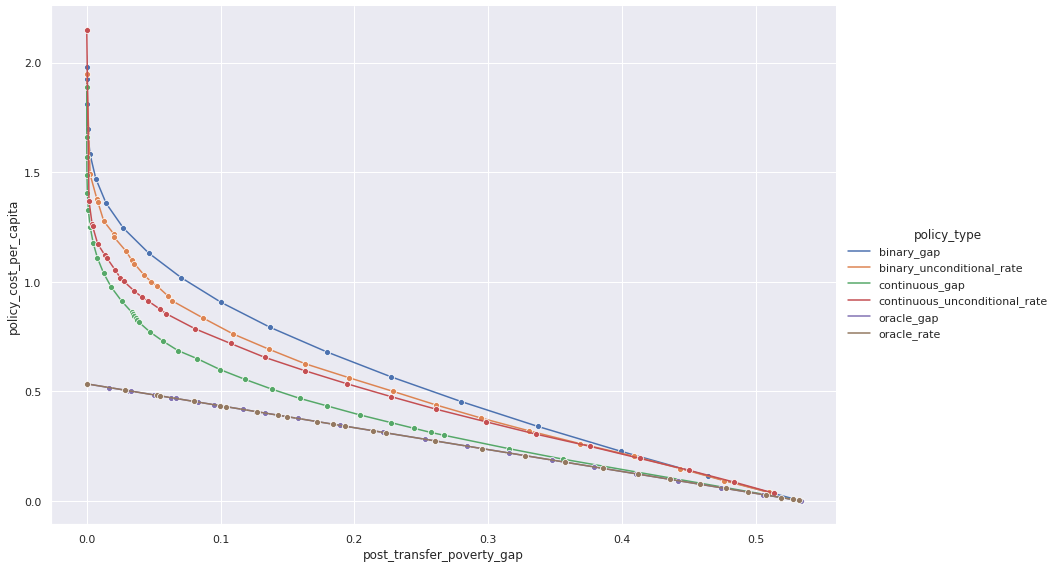

In [115]:
sns.relplot(
    data=all_results,
    x='post_transfer_poverty_gap', y='policy_cost_per_capita', hue='policy_type',kind='line',
    marker='o', height=8, aspect=12/8
)